In [2]:
import pandas as pd
import json
import os
from sklearn.model_selection import train_test_split

In [3]:
pdbbind_general_dir = '../PDBBind/PDBbind_v2020_other_PL/v2020-other-PL/'
pdbbind_refined_dir = '../PDBBind/PDBbind_v2020_refined/refined-set/'

In [4]:
widths = [6,6,7,6,17,9,200]
cols = 'PDB code, resolution, release year, -logKd/Ki, Kd/Ki, reference, ligand name'.replace(', ', ',').split(',')
pl_data = pd.read_fwf(os.path.join(pdbbind_general_dir, 'index', 'INDEX_general_PL_data.2020'), widths=widths,skiprows=6,header=None)
pl_data.columns=cols

In [5]:
pl_data.head()

,PDB code,resolution,release year,-logKd/Ki,Kd/Ki,reference,ligand name
0,3zzf,2.20,2012,0.40,Ki=400mM //,3zzf.pdf,(NLG)
1,3gww,2.46,2009,0.45,IC50=355mM //,3gwu.pdf,(SFX)
2,1w8l,1.80,2004,0.49,Ki=320mM //,1w8l.pdf,(1P3)
3,3fqa,2.35,2009,0.49,IC50=320mM //,3fq7.pdf,(GAB&PMP)
4,1zsb,2.00,1996,0.60,Kd=250mM //,1zsb.pdf,(AZM)


In [6]:
widths = [6,6,8,200]
cols = 'PDB code, release year, Uniprot ID, protein name'.replace(', ', ',').split(',')
pl_name = pd.read_fwf(os.path.join(pdbbind_general_dir, 'index', 'INDEX_general_PL_name.2020'), widths=widths,skiprows=6,header=None)
pl_name.columns=cols

In [7]:
pl_name.head()

,PDB code,release year,Uniprot ID,protein name
0,6mu1,2018,P29994,"INOSITOL 1,4,5-TRISPHOSPHATE RECEPTOR TYPE 1"
1,3t8s,2011,P29994,"INOSITOL 1,4,5-TRISPHOSPHATE RECEPTOR TYPE 1"
2,1n4k,2002,P11881,"INOSITOL 1,4,5-TRISPHOSPHATE RECEPTOR TYPE 1"
3,5urm,2017,O75643,U5 SMALL NUCLEAR RIBONUCLEOPROTEIN 200 KDA HEL...
4,5urj,2017,O75643,U5 SMALL NUCLEAR RIBONUCLEOPROTEIN 200 KDA HEL...


In [8]:
widths = [6,6,6,17,9,200]
cols = 'PDB code, resolution, release year, binding data, reference, ligand name'.replace(', ', ',').split(',')
pl_general = pd.read_fwf(os.path.join(pdbbind_general_dir, 'index', 'INDEX_general_PL.2020'), widths=widths,skiprows=6,header=None)
pl_general.columns=cols

In [9]:
pl_general.head()

,PDB code,resolution,release year,binding data,reference,ligand name
0,2tpi,2.10,1982,Kd=49uM //,2tpi.pdf,(2-mer)
1,5tln,2.30,1982,Ki=0.43uM //,5tln.pdf,(BAN) incomplete ligand structure
2,4tln,2.30,1982,Ki=190uM //,4tln.pdf,(LNO)
3,4cts,2.90,1984,Kd<10uM //,4cts.pdf,(OAA)
4,6rsa,NMR,1986,Ki=40uM //,6rsa.pdf,(UVC)


In [10]:
pl_general['remark'] = pl_general['ligand name'].str.split(')')
pl_general['remark'] = pl_general['remark'].apply(lambda x : x[1])

In [11]:
def clean_activity_data(string) :
    
    def find_sep(string) :
        if '=' in string :
            return '='
        elif '<' in string :
            return '<'
        elif '>' in string :
            return '>'
        else :
            return '~'
        
    sep = find_sep(string)
    splitted_string = string.split(sep)
    value_unit = splitted_string[1]
    
    parsed=False
    i=0
    value=''
    units=''
    while not parsed :
        char = value_unit[i]
        if char in '0123456789.' :
            value = value + char
        elif char == ' ' :
            parsed=True
        else :
            units = units + char
        i = i + 1
    return [units, sep, value]

pl_data['activity_list'] = pl_data['Kd/Ki'].apply(clean_activity_data)
#pl_general['units'] = pl_general['activity'].apply(lambda x : x[0])
pl_data['sep'] = pl_data['activity_list'].apply(lambda x : x[1])

def standard_activity(l) :
    """get all activity in nanomolar"""
    unit, sep, value = l
    value = float(value)
    if unit == 'uM' :
        value = value * 1000
    elif unit == 'mM' :
        value = value * 1000000
    elif unit == 'pM' :
        value = value / 1000
    elif unit == 'fM' :
        value = value / 1000000
    
    return value

pl_data['value'] = pl_data['activity_list'].apply(standard_activity)
pl_data['units'] = 'nM'

In [12]:
pl_data.head()

,PDB code,resolution,release year,-logKd/Ki,Kd/Ki,reference,ligand name,activity_list,sep,value,units
0,3zzf,2.20,2012,0.40,Ki=400mM //,3zzf.pdf,(NLG),"[mM, =, 400]",=,400000000.0,nM
1,3gww,2.46,2009,0.45,IC50=355mM //,3gwu.pdf,(SFX),"[mM, =, 355]",=,355000000.0,nM
2,1w8l,1.80,2004,0.49,Ki=320mM //,1w8l.pdf,(1P3),"[mM, =, 320]",=,320000000.0,nM
3,3fqa,2.35,2009,0.49,IC50=320mM //,3fq7.pdf,(GAB&PMP),"[mM, =, 320]",=,320000000.0,nM
4,1zsb,2.00,1996,0.60,Kd=250mM //,1zsb.pdf,(AZM),"[mM, =, 250]",=,250000000.0,nM


In [13]:
pl_data['sep'].value_counts()

=    18947
>      215
<      149
~      132
Name: sep, dtype: int64

In [14]:
pl_data['units'].value_counts()

nM    19443
Name: units, dtype: int64

In [15]:
pl_data['active'] = (pl_data['value'] < 1000) & (pl_data['sep'] != '~')

In [16]:
pl_data['active'].value_counts()

True     11259
False     8184
Name: active, dtype: int64

In [17]:
pl_all = pl_data.merge(pl_name, on='PDB code')

In [18]:
pl_data_nomer = pl_data[pl_data['ligand name'].apply(lambda x : not 'mer' in x)]
ligand_counts = pl_data_nomer['ligand name'].value_counts()

In [19]:
ligand_counts = pd.DataFrame(ligand_counts)

In [20]:
for ligand in ligand_counts.index :
    pl_ligand = pl_all[pl_all['ligand name'] == ligand]
    ligand_counts.loc[ligand, 'unique protein'] = len(pl_ligand['protein name'].unique())

In [21]:
top50_ligand_counts = ligand_counts[:50]
top50_ligand = top50_ligand_counts.index.tolist()

In [22]:
unique_ligands = pl_data['ligand name'].unique()

In [23]:
top50_ligand_counts.head()

,ligand name,unique protein
(ADP),80,63.0
(ATP),75,57.0
(GDP),56,46.0
(017),40,5.0
(SAH),39,33.0


In [24]:
frac_train = 0.8

In [25]:
from collections import Counter

In [26]:
available_structures = os.listdir(pdbbind_general_dir) + os.listdir(pdbbind_refined_dir)
train_set = {}
test_set = {}
for lig in top50_ligand_counts.index :
    pl_lig = pl_all[pl_all['ligand name'] == lig]
    pl_lig = pl_lig[pl_lig['PDB code'].isin(available_structures)]
    
    if len(pl_lig) > 10 :
        train_pdbs = []
        test_pdbs = []
        counter = Counter()
        counter.update(pl_lig['protein name'].values)
        if len(counter) > 1 :
            for prot_name, count in counter.most_common() :
                pdb_ids = pl_lig[pl_lig['protein name'] == prot_name]['PDB code'].values
                if len(train_pdbs) < len(pl_lig) * 0.7 :
                    train_pdbs.extend(pdb_ids)
                else :
                    test_pdbs.extend(pdb_ids)
            train_set[lig] = train_pdbs
            test_set[lig] = test_pdbs

In [27]:
import numpy as np
import json
import pickle
import os
from ase.io import read as aseread

from dscribe.descriptors import SOAP

from scipy.spatial.distance import euclidean
from scipy.spatial import distance_matrix
from collections import defaultdict
from Bio.PDB import PDBParser, PPBuilder

import warnings
warnings.filterwarnings('ignore')

In [28]:
pdbbind_general_dir = '../PDBBind/PDBbind_v2020_other_PL/v2020-other-PL/'
pdbbind_refined_dir = '../PDBBind/PDBbind_v2020_refined/refined-set/'

In [29]:
def get_soap_calculator(rcut=5, nmax=8, lmax=4, sigma=1):
    return SOAP(
        rcut = rcut,
        nmax = nmax,
        lmax = lmax,
        sigma = sigma,
        species = "C,N,O,S".split(",")
    )

In [30]:
def get_protein_config(prot_id, input_dirs=['../PDBBind/PDBbind_v2020_other_PL/v2020-other-PL/',
                                                      '../PDBBind/PDBbind_v2020_refined/refined-set/']) :
    """
    Returns an Atoms object of the protein for a given pdb + chain names 
    (and class to look in the right directory)
    """

    if prot_id in os.listdir(input_dirs[0]) :
        protein_path = os.path.join(input_dirs[0], prot_id, f'{prot_id}_protein.pdb')
    else :
        protein_path = os.path.join(input_dirs[1], prot_id, f'{prot_id}_protein.pdb')
        
    config = aseread(protein_path)
    config = config[[atom.index for atom in config if atom.symbol in ['C', 'N', 'O', 'S']]]
        
    return config

In [31]:
def get_ligand_config(prot_id, input_dirs=['../PDBBind/PDBbind_v2020_other_PL/v2020-other-PL/',
                                                      '../PDBBind/PDBbind_v2020_refined/refined-set/']) :
    """
    Returns an Atoms object for a given protein name (and class to look in the right directory)
    """
    
    if prot_id in os.listdir(input_dirs[0]) :
        ligand_path = os.path.join(input_dirs[0], prot_id, f'{prot_id}_ligand.sdf')
    else :
        ligand_path = os.path.join(input_dirs[1], prot_id, f'{prot_id}_ligand.sdf')
        
    config = aseread(ligand_path, format='sdf')

    # config = config[[atom.index for atom in config if atom.symbol in ['C', 'N', 'O', 'S']]] 
    # we comment out because we are interested in all ligand atoms positions
        
    return config

In [32]:
def sample_around_pos(calculator, config, position, shift_radius=0.5, sample_size=2) :
    """
    Sample SOAPS at positions around the given position
    """
    
    limited_config = config[distance_matrix(config.positions, position.reshape(1, -1)).max(1) < 10]
    
    shifts = (np.random.rand(sample_size, 3) - 0.5) * 2 * shift_radius
    shifted_positions = shifts + position
    
    soaps = []
    for shifted_position in shifted_positions :
        soaps.append(calculator.create(system=config, positions=[shifted_position.tolist()])[0])
        #soaps.append(calculator.create(system=config, positions=[shifted_position.tolist()])[0])
                
    return soaps

In [33]:
def random_sample_protein(calculator, config, ligand_positions, sample_size=5) :
    """
    Sample SOAPS at random positions in the protein, only if they are not close to ligand
    """
    
    config_mins = config.positions.min(axis=0).astype(int) - 5
    config_maxs = config.positions.max(axis=0).astype(int) + 5
    
    soaps = []
    random_positions = np.random.rand(sample_size, 3) * (config_maxs - config_mins) + config_mins
    for position in random_positions :
        close_to_ligand = any([euclidean(position, ligand_position) < 3 for ligand_position in ligand_positions])
        if not close_to_ligand : # avoid putting positive (close to the ligand) soaps in random = negative soaps
            soap = calculator.create(system=config, positions=[position.tolist()])[0]
            if not any(np.isnan(soap)) : # avoid soap errors
                soaps.append(soap)
    
    return soaps

In [34]:
data_dir = 'data/'

In [35]:
training_set = json.load(open("data/pdbbind_ligand_training_set.json")) # {kinase_class : [prot_id1, prot_id2...]}
test_set = json.load(open("data/pdbbind_ligand_test_set.json"))

In [36]:
%%time

training_soaps = defaultdict(list) # {class_id : [soap1, soap2...]} with soap = [value1, ..., value1800]

for class_id in training_set :
    
    for prot_id in training_set[class_id] :

        prot_soaps = []
        try :
        
            calculator = get_soap_calculator()

            protein_config = get_protein_config(prot_id)
            ligand_config = get_ligand_config(prot_id)
            
            for position in ligand_config.positions :
                soaps = sample_around_pos(calculator, protein_config, position)
                prot_soaps.extend(soaps)
                
            training_soaps[class_id].append(np.mean(soaps, axis=0))
            
        except : 
            print('Error reading ' + prot_id)
    
    training_soaps[class_id] = np.array(training_soaps[class_id])
    print(class_id + ' done')
    print(training_soaps[class_id].shape)
    
training_soaps['random'] = np.array(training_soaps['random'])

(ADP) done
(56, 2640)
(ATP) done
(53, 2640)
(GDP) done
(40, 2640)
(017) done
(34, 2640)
(SAH) done
(28, 2640)
(C2E) done
(24, 2640)
(AMP) done
(21, 2640)
(BTN) done
(20, 2640)
(ARG) done
(19, 2640)
(SAM) done
(17, 2640)
(G39) done
(20, 2640)
(STU) done
(16, 2640)
(GLU) done
(16, 2640)
(BEN) done
(17, 2640)
(PGA) done
(13, 2640)
(GTP) done
(13, 2640)
(ANP) done
(13, 2640)
(AZM) done
(12, 2640)
(TRP) done
(12, 2640)
(CIT) done
(12, 2640)
Error reading 4qgi
Error reading 3ekq
Error reading 3el4
Error reading 3cyx
Error reading 3d1y
Error reading 2nmy
Error reading 2nmz
Error reading 2nnk
Error reading 2nnp
Error reading 3oxc
Error reading 3d1x
Error reading 3s56
Error reading 1hxb
(ROC) done
(0,)
Error reading 2avq
Error reading 2aoc
Error reading 2aod
Error reading 2avm
Error reading 2aog
Error reading 6o57
Error reading 6o5a
Error reading 3hau
Error reading 3bva
Error reading 3hdk
Error reading 3hbo
Error reading 3iaw
(2NC) done
(0,)
(ADN) done
(12, 2640)
(DAN) done
(12, 2640)
(CMP) don

# Compute SOAPS for test set

In [39]:
%%time

test_soaps = defaultdict(list)

for class_id in test_set :
    
    for prot_id in test_set[class_id] :

        try :
        
            calculator = get_soap_calculator()

            protein_config = get_protein_config(prot_id)
            ligand_config = get_ligand_config(prot_id)
            
            for position in ligand_config.positions :
                soaps = sample_around_pos(calculator, protein_config, position)
                prot_soaps.extend(soaps)
                
            test_soaps[class_id].append(np.mean(soaps, axis=0))
                
        except : 
            print('Error reading ' + prot_id)
    
    test_soaps[class_id] = np.array(test_soaps[class_id])
    print(class_id + ' done')
    print(test_soaps[class_id].shape)

(ADP) done
(24, 2640)
(ATP) done
(22, 2640)
(GDP) done
(16, 2640)
(017) done
(6, 2640)
(SAH) done
(11, 2640)
(C2E) done
(10, 2640)
(AMP) done
(9, 2640)
(BTN) done
(8, 2640)
(ARG) done
(7, 2640)
Error reading 2adm
(SAM) done
(5, 2640)
(G39) done
(3, 2640)
(STU) done
(6, 2640)
(GLU) done
(6, 2640)
(BEN) done
(3, 2640)
(PGA) done
(5, 2640)
(GTP) done
(5, 2640)
(ANP) done
(5, 2640)
(AZM) done
(5, 2640)
(TRP) done
(5, 2640)
(CIT) done
(4, 2640)
Error reading 3pww
Error reading 5kqx
Error reading 5kr2
(ROC) done
(0,)
Error reading 3haw
Error reading 3hlo
Error reading 3ka2
Error reading 3fsm
(2NC) done
(0,)
(ADN) done
(4, 2640)
(DAN) done
(4, 2640)
(CMP) done
(4, 2640)
Error reading 2p3d
Error reading 3slz
(3TL) done
(1, 2640)
(478) done
(3, 2640)
(OAN) done
(3, 2640)
(5GP) done
(4, 2640)
(GSH) done
(4, 2640)
(RET) done
(3, 2640)
(AKG) done
(3, 2640)
(AGS) done
(3, 2640)
(ZMR) done
(3, 2640)
(MK1) done
(1, 2640)
(BO2) done
(1, 2640)
(U5P) done
(3, 2640)
(GNP) done
(3, 2640)
(BB2) done
(3, 26

In [40]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

In [41]:
data_dir = 'data/'

In [43]:
X = np.empty((0, training_soaps['(ADP)'].shape[1]))
Y = []

for class_id in training_soaps :
    if class_id != 'random' :
        if len(training_soaps[class_id]) :
            X = np.vstack((X, training_soaps[class_id]))
            Y += [class_id for _ in range(training_soaps[class_id].shape[0])]
        
X_train = X
Y_train = Y

In [44]:
training_soaps['(BO2)'].shape

(12, 2640)

In [46]:
X_test = np.empty((0, training_soaps['(ADP)'].shape[1]))
Y_test = []

for class_id in test_soaps :
    if class_id != 'random' :
        if len(training_soaps[class_id]) :
            X_test = np.vstack((X_test, test_soaps[class_id]))
            Y_test += [class_id for _ in range(test_soaps[class_id].shape[0])]
        
#Y_test = enc.fit_transform(np.array(Y_test).reshape(-1,1)).toarray()

In [47]:
rf = RandomForestClassifier(n_jobs=18)
rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=18, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [48]:
Y_pred = rf.predict(X_train)

In [49]:
class_ids = np.array(sorted(list(set(Y_train))))

In [50]:
# Classification task, taking the regressor having the maximum value as the pred label for a sample
# Plot the confusion matrix
plt.figure(figsize=(10, 10))
conf_mat = confusion_matrix(Y_train, Y_pred, labels=class_ids)
plt.imshow(conf_mat)

In [51]:
print(f"Balanced accuracy : {balanced_accuracy_score(Y_train, Y_pred)}")

Balanced accuracy : 1.0


In [52]:
recalls = np.diag(conf_mat) / conf_mat.sum(1)
# sorting the recall (and precision later) in decreasing order
sorted_idx = recalls.argsort()[::-1]
sorted_cats = class_ids[sorted_idx]
sorted_recalls = recalls[sorted_idx]

In [53]:
sns.set_theme(style="whitegrid")

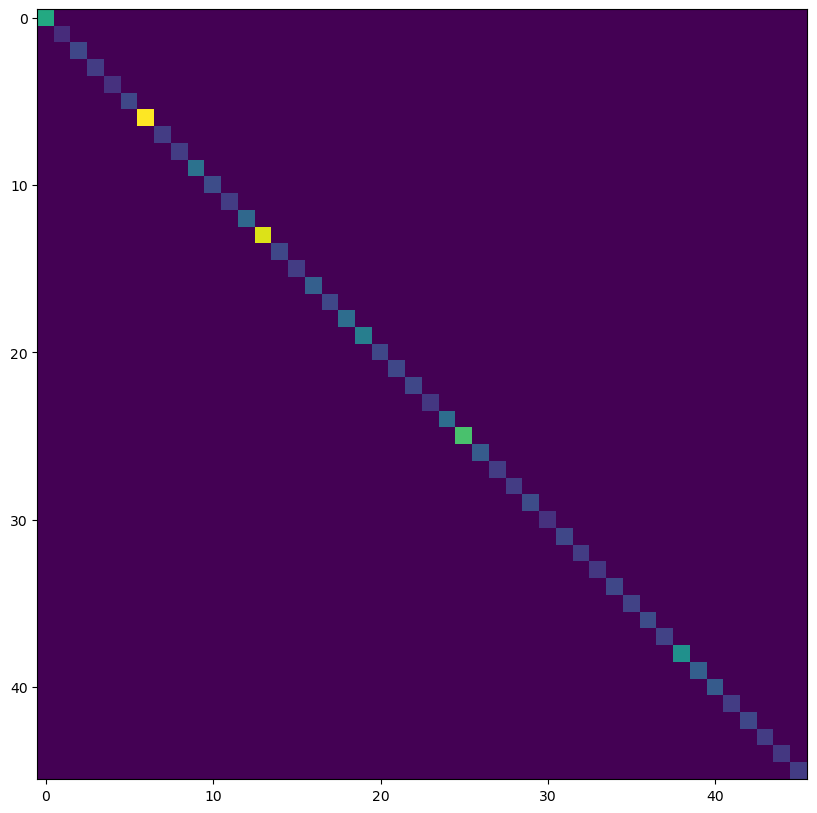

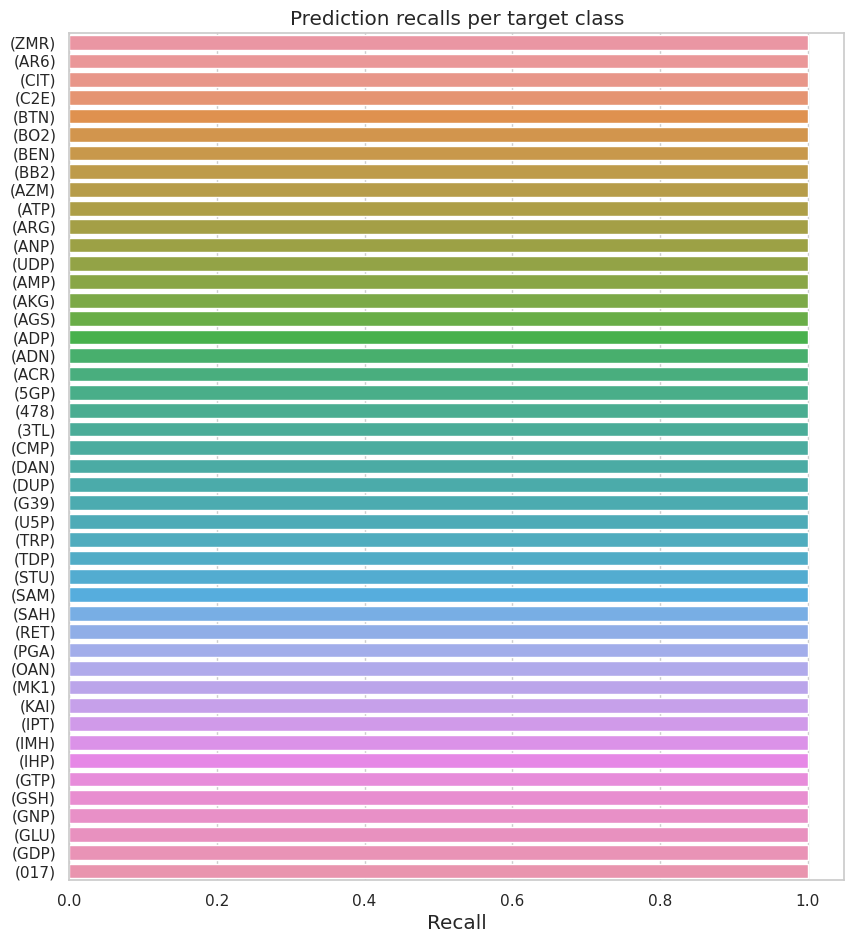

In [54]:
# Recall per target
plt.figure(figsize=(10,11))
sns.barplot(x=sorted_recalls, y=sorted_cats, orient='h')
plt.title('Prediction recalls per target class', fontsize='large')
plt.xlabel('Recall', fontsize='large')
#plt.savefig(f"{figures_dir}recalls_{plot_suffix}.{image_format}", bbox_inches='tight', format=image_format)
plt.show()

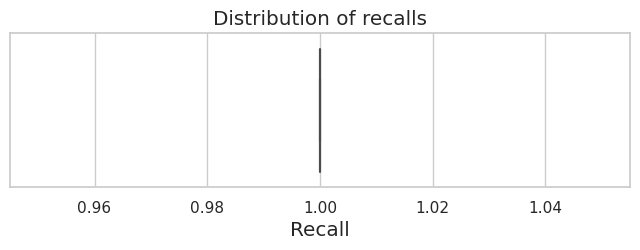

In [55]:
# Distributions of recalls
plt.figure(figsize=(8,2))
sns.boxplot(sorted_recalls)
plt.title('Distribution of recalls', fontsize='large')
plt.xlabel('Recall', fontsize='large')
#plt.savefig(f"{figures_dir}recalls_distribution_{plot_suffix}.{image_format}", bbox_inches='tight', format=image_format)
plt.show()

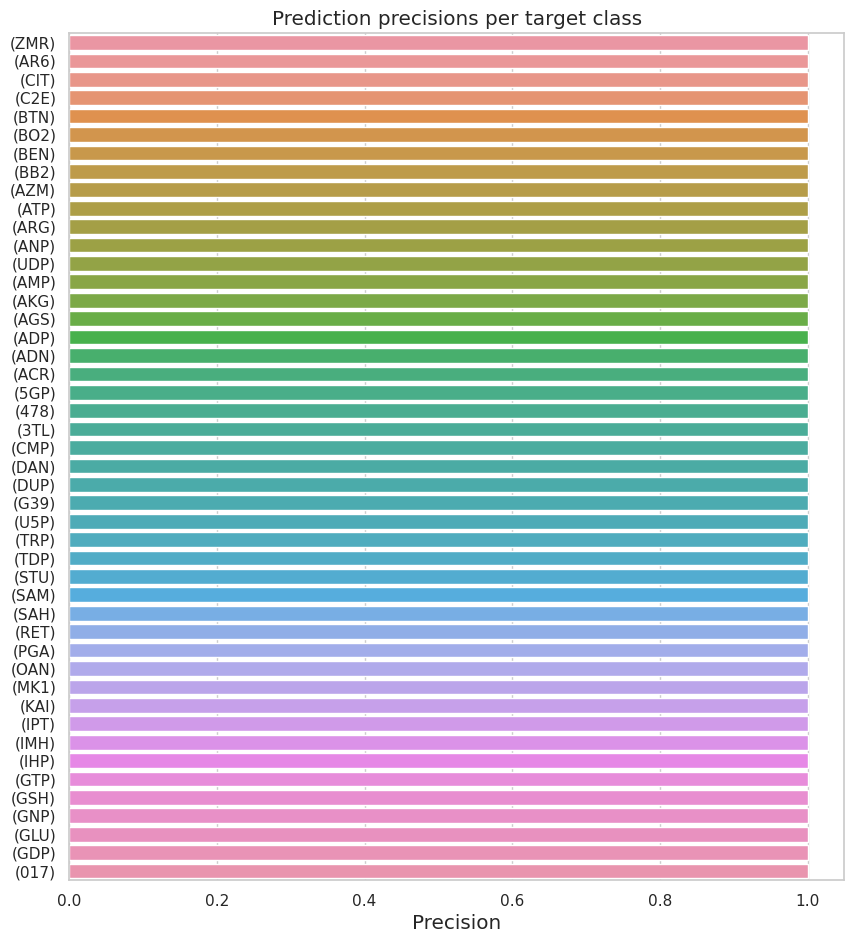

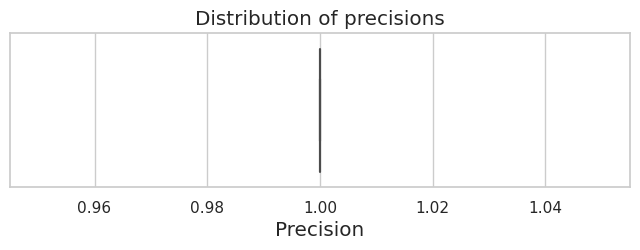

In [56]:
    # Precisions
    precisions = np.diag(conf_mat) / conf_mat.sum(0)
    precisions = np.where(np.isnan(precisions), 0, precisions)
    
    sorted_idx = precisions.argsort()[::-1]
    sorted_cats = class_ids[sorted_idx]
    sorted_precisions = precisions[sorted_idx]
    
    # Precision per target
    plt.figure(figsize=(10,11))
    sns.barplot(x=sorted_precisions, y=sorted_cats, orient='h')
    plt.title('Prediction precisions per target class', fontsize='large')
    plt.xlabel('Precision', fontsize='large')
    #plt.savefig(f"{figures_dir}precisions_{plot_suffix}.{image_format}", bbox_inches='tight', format=image_format)
    plt.show()
    
    # Distribution of precisions
    plt.figure(figsize=(8,2))
    sns.boxplot(sorted_precisions)
    plt.title('Distribution of precisions', fontsize='large')
    plt.xlabel('Precision', fontsize='large')
    #plt.savefig(f"{figures_dir}precisions_distribution_{plot_suffix}.{image_format}", bbox_inches='tight', format=image_format)
    plt.show()

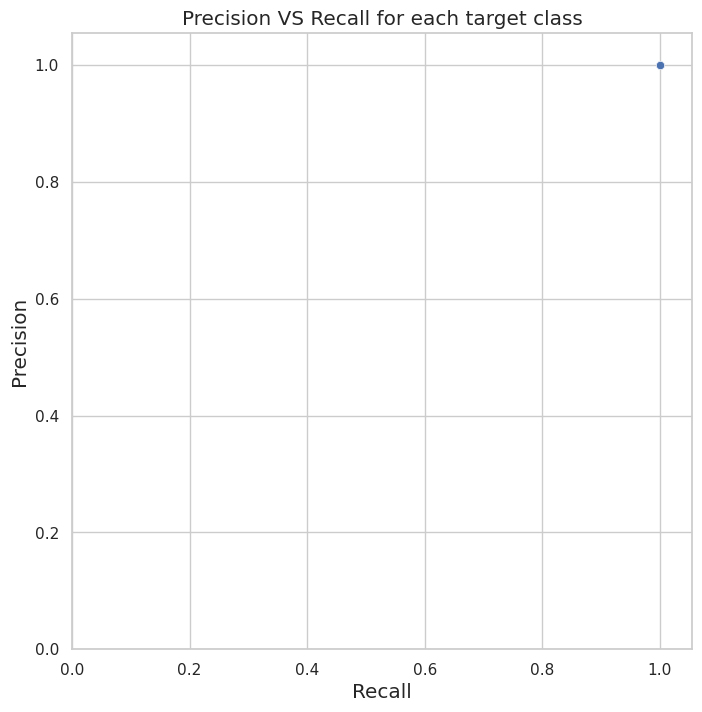

In [57]:
    # Precision VS Recall
    plt.figure(figsize=(8,8))
    sns.scatterplot(recalls, precisions)
    plt.xlim(0)
    plt.ylim(0)
    plt.title('Precision VS Recall for each target class', fontsize='large')
    plt.xlabel('Recall', fontsize='large')
    plt.ylabel('Precision', fontsize='large')
    #plt.savefig(f"{figures_dir}precisions_vs_recalls_{plot_suffix}.{image_format}", bbox_inches='tight', format=image_format)
    plt.show()

In [58]:
Y_pred = rf.predict(X_test)

In [59]:
class_ids = np.array(sorted(list(set(Y_train))))

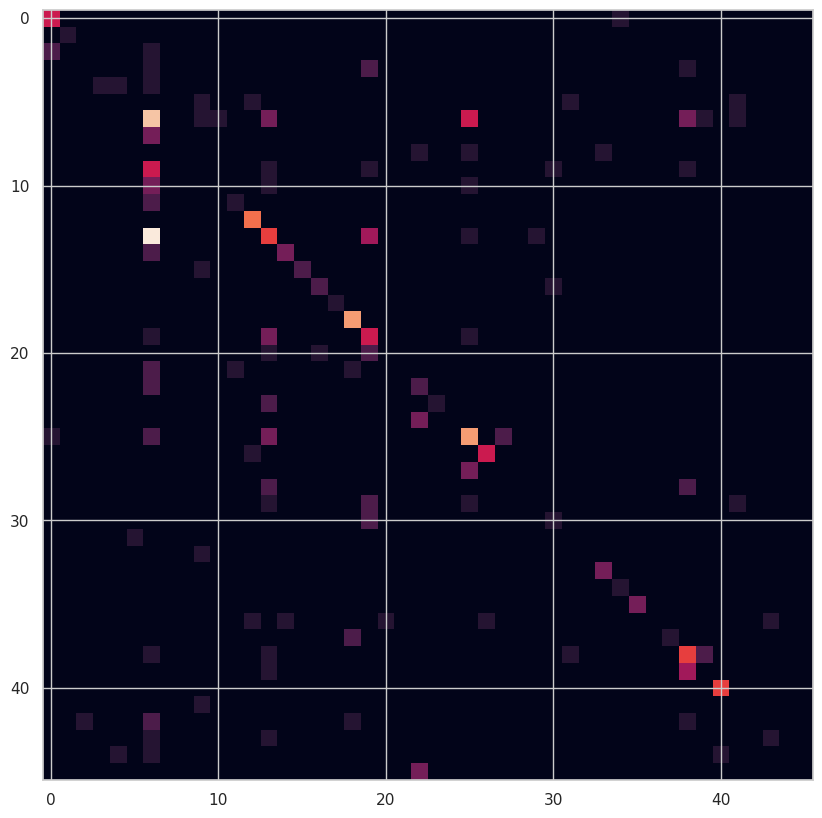

In [70]:
# Classification task, taking the regressor having the maximum value as the pred label for a sample
# Plot the confusion matrix
plt.figure(figsize=(10, 10))
conf_mat = confusion_matrix(Y_test, Y_pred, labels=class_ids)
plt.imshow(conf_mat)
plt.show()

In [71]:
print(f"Balanced accuracy : {balanced_accuracy_score(Y_test, Y_pred)}")

Balanced accuracy : 0.354199604743083


In [72]:
recalls = np.diag(conf_mat) / conf_mat.sum(1)
# sorting the recall (and precision later) in decreasing order
sorted_idx = recalls.argsort()[::-1]
sorted_cats = class_ids[sorted_idx]
sorted_recalls = recalls[sorted_idx]

In [73]:
sns.set_theme(style="whitegrid")

In [74]:
feature_importance = rf.feature_importances_

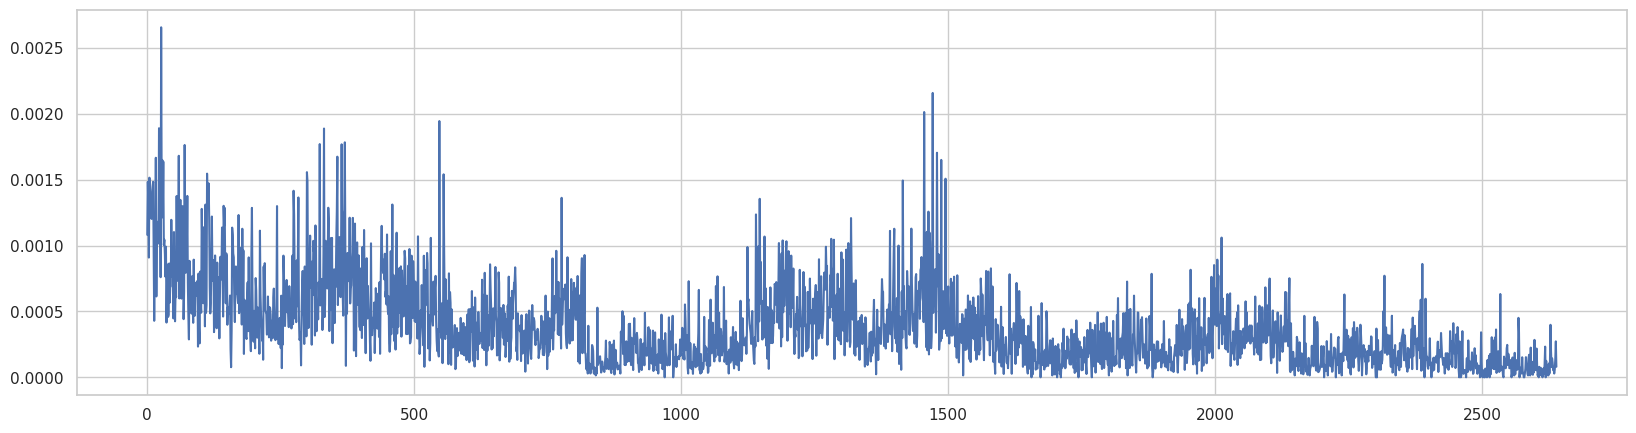

In [75]:
plt.figure(figsize=(20,5))
plt.plot(feature_importance)
plt.show()

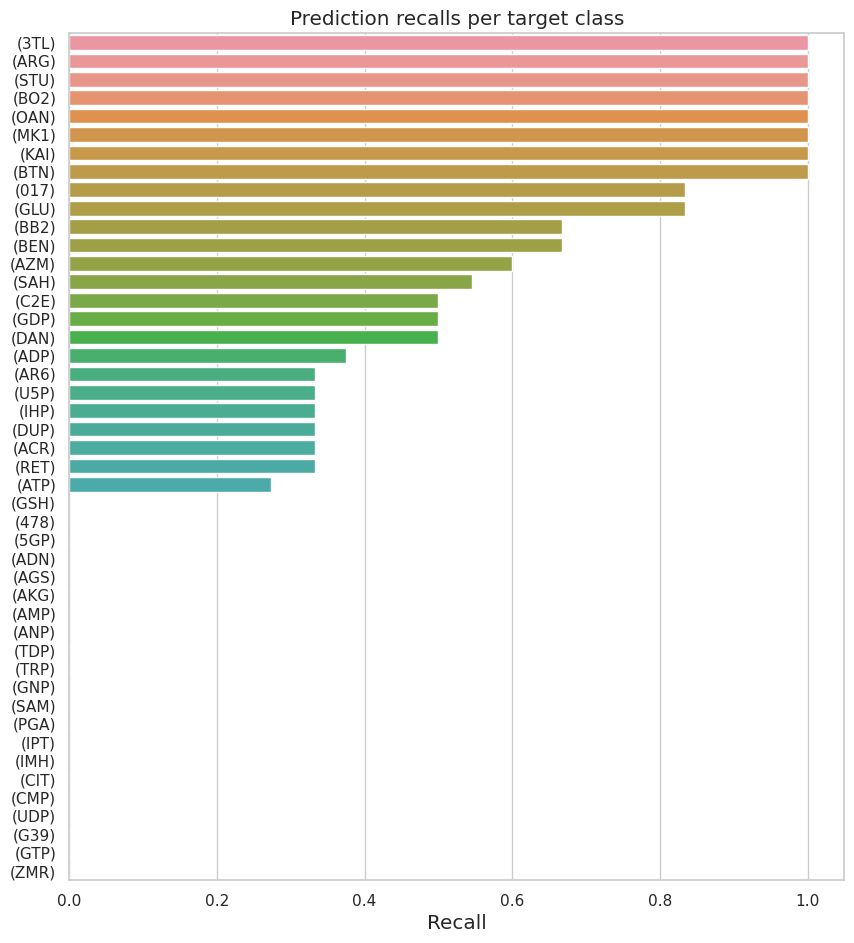

In [66]:
# Recall per target
plt.figure(figsize=(10,11))
sns.barplot(x=sorted_recalls, y=sorted_cats, orient='h')
plt.title('Prediction recalls per target class', fontsize='large')
plt.xlabel('Recall', fontsize='large')
#plt.savefig(f"{figures_dir}recalls_{plot_suffix}.{image_format}", bbox_inches='tight', format=image_format)
plt.show()

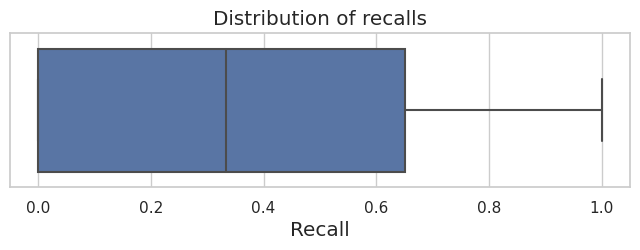

In [67]:
# Distributions of recalls
plt.figure(figsize=(8,2))
sns.boxplot(sorted_recalls)
plt.title('Distribution of recalls', fontsize='large')
plt.xlabel('Recall', fontsize='large')
#plt.savefig(f"{figures_dir}recalls_distribution_{plot_suffix}.{image_format}", bbox_inches='tight', format=image_format)
plt.show()

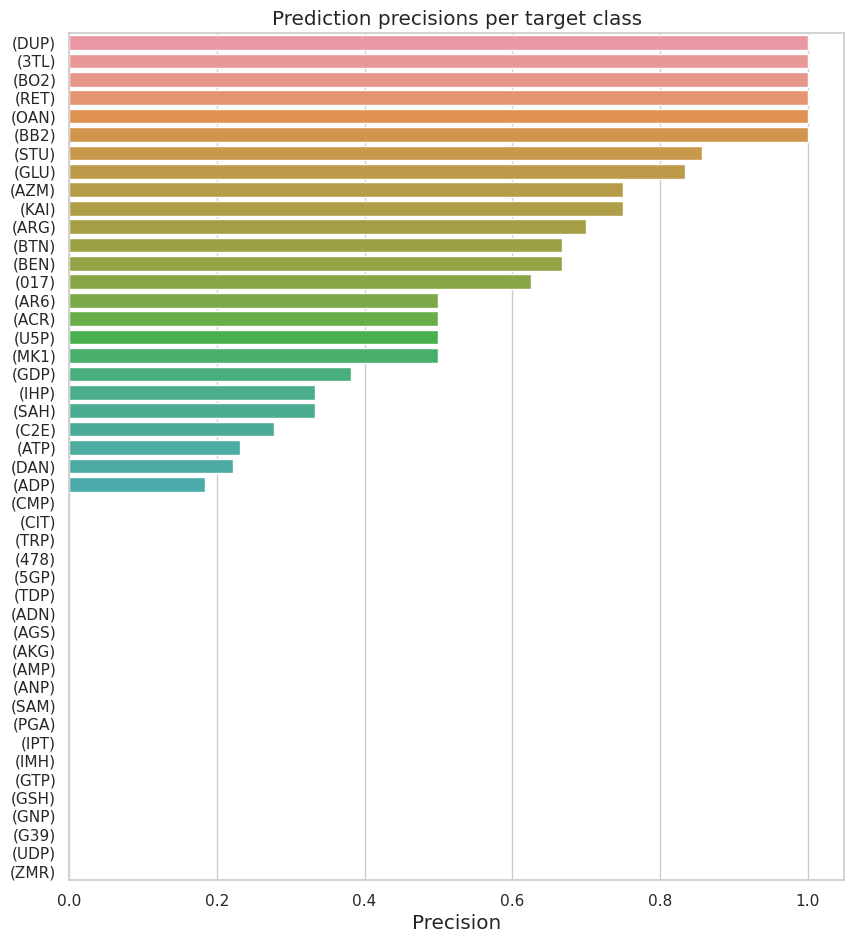

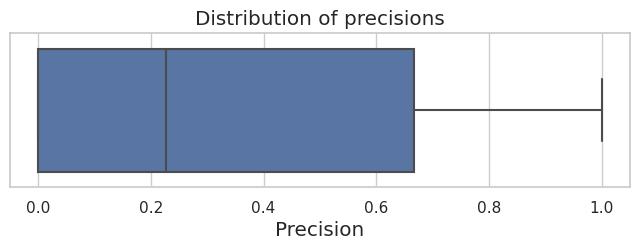

In [68]:
    # Precisions
    precisions = np.diag(conf_mat) / conf_mat.sum(0)
    precisions = np.where(np.isnan(precisions), 0, precisions)
    
    sorted_idx = precisions.argsort()[::-1]
    sorted_cats = class_ids[sorted_idx]
    sorted_precisions = precisions[sorted_idx]
    
    # Precision per target
    plt.figure(figsize=(10,11))
    sns.barplot(x=sorted_precisions, y=sorted_cats, orient='h')
    plt.title('Prediction precisions per target class', fontsize='large')
    plt.xlabel('Precision', fontsize='large')
    #plt.savefig(f"{figures_dir}precisions_{plot_suffix}.{image_format}", bbox_inches='tight', format=image_format)
    plt.show()
    
    # Distribution of precisions
    plt.figure(figsize=(8,2))
    sns.boxplot(sorted_precisions)
    plt.title('Distribution of precisions', fontsize='large')
    plt.xlabel('Precision', fontsize='large')
    #plt.savefig(f"{figures_dir}precisions_distribution_{plot_suffix}.{image_format}", bbox_inches='tight', format=image_format)
    plt.show()

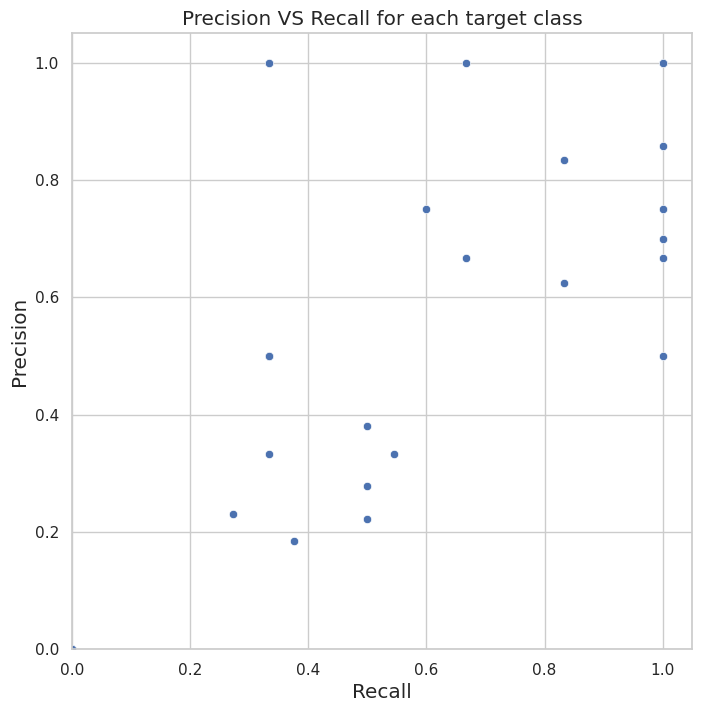

In [69]:
    # Precision VS Recall
    plt.figure(figsize=(8,8))
    sns.scatterplot(recalls, precisions)
    plt.xlim(0)
    plt.ylim(0)
    plt.title('Precision VS Recall for each target class', fontsize='large')
    plt.xlabel('Recall', fontsize='large')
    plt.ylabel('Precision', fontsize='large')
    #plt.savefig(f"{figures_dir}precisions_vs_recalls_{plot_suffix}.{image_format}", bbox_inches='tight', format=image_format)
    plt.show()